In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Date, cast, distinct

In [5]:
db_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{db_path}", echo=False)

In [6]:
Base = automap_base()

In [7]:
# reflect an existing database into a new model

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
weather = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Last 12 Months

In [11]:
# find dates for queries: current date, 12 months ago
#current date
desc_dates = session.query(weather.date).order_by(weather.date.desc()).all()

cur_date = str(*desc_dates[0])
cur_date_yr = int(cur_date[0 : 4])
cur_date_mth = int(cur_date[6 : 7])
cur_date_day = int(cur_date[8 : 10])

# 12 months ago
twelve_months_ago = dt.date(cur_date_yr,cur_date_mth,cur_date_day) - dt.timedelta(days=365)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data
py = session.query(weather.date,weather.prcp).\
                filter(weather.date > twelve_months_ago).all()
py_df = pd.DataFrame(py)
py_df = py_df.sort_values(by='date', ascending=True)

[]

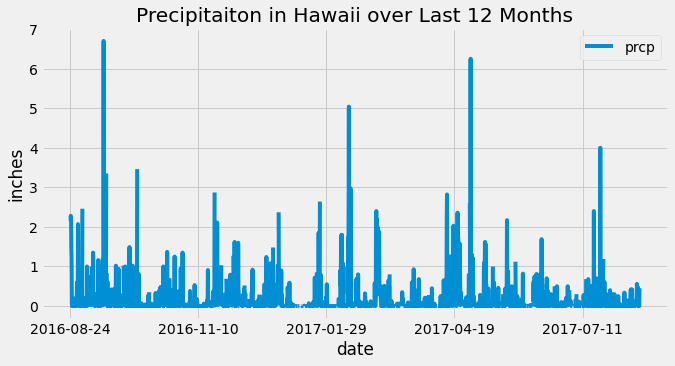

In [13]:
# plot the results for last 12 months
py_chart = py_df.plot.line(x='date', title="Precipitaiton in Hawaii over Last 12 Months",figsize=(10,5))
py_chart.set_xlabel("date")
py_chart.set_ylabel("inches")
py_chart.plot()

### First Year (of available data)

In [15]:
# Calculate the date 1 year ago from the last data point in the database
# first date
asc_dates = session.query(weather.date).order_by(weather.date.asc()).all()

#one year after last date
first_date = str(*asc_dates[0])
first_date_yr = int(first_date[0 : 4])
first_date_mth = int(first_date[6 : 7])
first_date_day = int(first_date[8 : 10])

first_plus_one = dt.date(first_date_yr,first_date_mth,first_date_day) + dt.timedelta(days=365)

In [16]:
# Perform a query to retrieve the data and precipitation scores
fy = session.query(weather.date,weather.prcp).\
                filter(weather.date > first_date).\
                filter(weather.date < first_plus_one).all()
fy_df = pd.DataFrame(fy)
fy_df = fy_df.sort_values(by='date', ascending=True)

[]

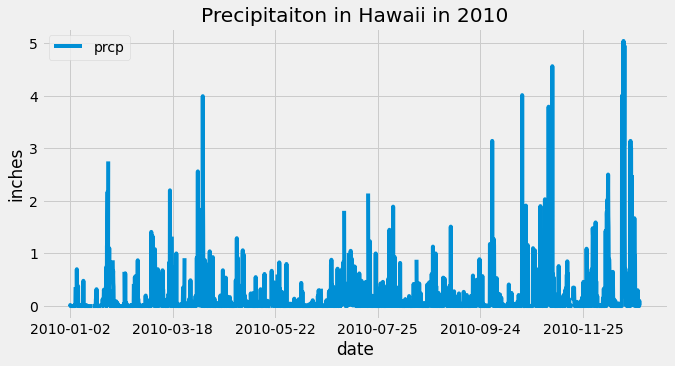

In [17]:
# plot the results for first year of data
fy_chart = fy_df.plot.line(x='date', title="Precipitaiton in Hawaii in 2010",figsize=(10,5))
fy_chart.set_xlabel("date")
fy_chart.set_ylabel("inches")
fy_chart.plot()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data = session.query(weather.id, weather.station,weather.date,weather.prcp,weather.tobs).all()
prcp_df = pd.DataFrame(prcp_data).dropna()

avg_prcp = prcp_df['prcp'].mean()
median_prcp = prcp_df['prcp'].median()
max_prcp = prcp_df['prcp'].max()
min_prcp = prcp_df['prcp'].min()
std_prcp = prcp_df['prcp'].std()

prcp_stats = pd.DataFrame({"Average Prcp" : [avg_prcp],
                          "Median Prcp" : median_prcp,
                          "Maximum Prcp" : max_prcp,
                          "Minimum Prcp" : min_prcp,
                          "Standard Deviation Prcp" : std_prcp})
prcp_stats

,Average Prcp,Median Prcp,Maximum Prcp,Minimum Prcp,Standard Deviation Prcp
0,0.160644,0.01,11.53,0.0,0.468746


In [19]:
# Design a query to show how many stations are available in this dataset?
# code referenced https://stackoverflow.com/questions/16728904/sqlalchemy-count-of-distinct-over-multiple-columns
stations = session.query(func.count(distinct(weather.station))).scalar()
print(f"Number of Stations in Data Base: {stations}")

Number of Stations in Data Base: 9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_cnt = prcp_df.groupby('station',as_index=False).agg({'id' : 'count'})
station_cnt = station_cnt.sort_values(by='id', ascending=False)
station_cnt = station_cnt.rename(columns={'id' : 'Activity Records'})
print(f"Most Active Station: USC00519281")

Most Active Station: USC00519281


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = prcp_df.groupby('station',as_index=False).agg({'tobs' : ['min','max', 'mean']})
temps_most_active = pd.DataFrame(temp.loc[temp['station'] == 'USC00519281'])
temps_most_active

station  tobs                 
                 min   max       mean
6  USC00519281  54.0  85.0  71.663781

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station = session.query(weather.tobs).\
                filter(weather.date > twelve_months_ago).\
                filter(weather.station == 'USC00519281').all()
ts_df = pd.DataFrame(top_station)

[]

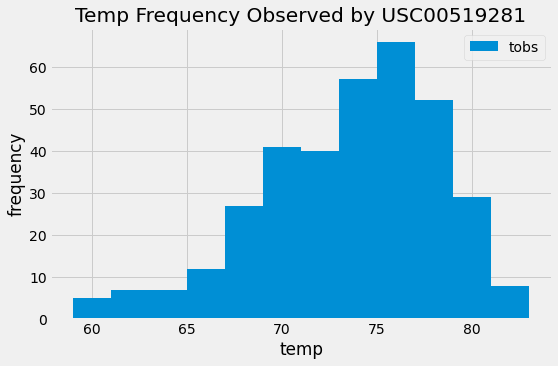

In [25]:
ts_chart = ts_df.plot.hist(by='tobs',bins=12, title="Temp Frequency Observed by USC00519281",figsize=(8,5))
ts_chart.set_xlabel("temp")
ts_chart.set_ylabel("frequency")
ts_chart.plot()